# Домашнее задание 2. Преобразование данных

Импорт библиотек:

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import sklearn.preprocessing as sp
import csv
import re
import dateutil
import matplotlib.patches as mpatches

np.set_printoptions(linewidth=150, precision=3, suppress=True)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ts_parser = lambda date_str: (datetime.datetime.strptime(date_str, "%Y-%m")).strftime("%Y-%m") if pd.notnull(date_str) and date_str else None
df_users = pd.read_csv("hw1_out.csv", sep=",", encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC, converters={"created_at": ts_parser})
# Remove rows with users not found
df_users = df_users[pd.notnull(df_users["name"])]
df_users["lat"].fillna(value=0, inplace=True)
df_users["lon"].fillna(value=0, inplace=True)
df_users.head(2)

,uid,cat,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,40585382,1,Reverend Sue,ReverendSue,Retired Interfaith Minister. Activist. Equalit...,False,United States,39.76000,-98.50000,United States,2009-05,7619,4283,50626,787,417
1,30005269,0,Ryan Wrasse,RWrasse,Communications Director for @SenJohnThune | Ge...,False,Capitol Hill,15.20825,145.75313,Northern Mariana Islands,2009-04,1910,1240,7135,128,96


Заведём для каждого пользователя дополнительные признаки и добавим их в датафрейм:

In [3]:
def create_new_features(df_users, features):
    new_features = ["name_words", "screen_name_length", "description_length", "created_year", "country_code", "verified"]
    countries={}
    for i in df_users.index:
        if df_users["country"][i] not in countries:
            countries[df_users["country"][i]]=len(countries)
    records=[]
    for i in df_users.index:
        record={
            "uid":df_users["uid"][i],
            "name_words": len((df_users["name"][i]).split()),
            "screen_name_length":len(df_users["screen_name"][i]),
            "description_length":len(df_users["description"][i]) if df_users["description"][i] is not nan else 0,
            "created_year":int(datetime.datetime.strptime(df_users["created_at"][i],"%Y-%m").strftime("%Y")),
            "country_code":countries[df_users["country"][i]],
            "verified":1 if df_users["verified"][i]==True else 0
        }
        records.append(record)
        
    df_add = pd.DataFrame(records, columns=["uid", "name_words", "screen_name_length", "description_length", "created_year", "country_code", "verified"])
    df_users=df_users.drop("verified",1)
    df_users = pd.merge(df_users, df_add, on="uid", how="left")
    features += new_features
    df_users=df_users[["uid","cat"]+features]
    return df_users, features

In [4]:
features = ["lat", "lon", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
df_users, features = create_new_features(df_users, features)

x = df_users[pd.notnull(df_users.cat)][features].values
y = df_users[pd.notnull(df_users.cat)]["cat"].values
df_users.head()

,uid,cat,lat,lon,followers_count,friends_count,statuses_count,favourites_count,listed_count,name_words,screen_name_length,description_length,created_year,country_code,verified
0,40585382,1,39.76000,-98.50000,7619,4283,50626,787,417,2,11,116,2009,0,0
1,30005269,0,15.20825,145.75313,1910,1240,7135,128,96,2,7,157,2009,1,0
2,3314758074,0,29.76328,-95.36327,17648,12440,901,7001,157,2,14,144,2015,0,0
3,14311688,0,40.71427,-74.00597,1757,1292,7331,157,111,2,14,114,2008,0,0
4,110457801,0,0.00000,0.00000,1461,1189,37073,3308,79,2,7,151,2010,2,0


Посчитаем матрицу корреляций для найденных признаков:

In [5]:
def find_correlated_features(x, features):
    corrmatrix=np.corrcoef(x)
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            if (i < j) and (abs(corrmatrix[i,j])>0.2):
                print "Correlated features: %s + %s -> %.2f" % (feature_i, feature_j, corrmatrix[i,j])

In [6]:
find_correlated_features(x,features)

Correlated features: lat + lon -> 0.97
Correlated features: lat + friends_count -> 0.97
Correlated features: lat + statuses_count -> 0.99
Correlated features: lat + favourites_count -> 1.00
Correlated features: lat + listed_count -> 0.44
Correlated features: lat + screen_name_length -> 0.24
Correlated features: lat + created_year -> 0.97
Correlated features: lon + friends_count -> 1.00
Correlated features: lon + statuses_count -> 0.94
Correlated features: lon + favourites_count -> 0.96
Correlated features: lon + listed_count -> 0.63
Correlated features: lon + name_words -> 0.34
Correlated features: lon + screen_name_length -> 0.41
Correlated features: lon + description_length -> 0.24
Correlated features: lon + created_year -> 0.91
Correlated features: lon + country_code -> 0.34
Correlated features: lon + verified -> 0.21
Correlated features: followers_count + name_words -> 0.22
Correlated features: followers_count + screen_name_length -> 0.74
Correlated features: followers_count + coun

Опишем функции для построения гистограмм и графиков взаимного распределения для пар признаков:

In [7]:
def plot_two_features_scatter(x_i, x_j, y): 
    colors=[]
    for i in y:
        if i==0:
            colors.append("red")
        else:
            colors.append("green")
    pl.scatter(x_j,x_i,c=colors,edgecolors='none',alpha=1)
    
def plot_feature_histogram(x_i, y):
    x_zeros=[]
    x_ones=[]
    for i,cat in enumerate(y):
        if cat==0:
            x_zeros.append(x_i[i])
        else:
            x_ones.append(x_i[i])
    maximum=minimum=x_i[0]
    for i in x_i:
        if i>maximum:
            maximum=i
        if i<minimum:
            minimum=i
    bins = np.linspace(minimum, maximum, 15)
    pl.hist([x_zeros,x_ones],bins,histtype='bar',color=["red","green"])

def plot_dataset(x, y, features,axis_values=True,legend=False):
    pl.figure(figsize=(20,12))
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            if i != j:
                ax=pl.subplot(len(features),len(features),i*len(features)+j+1)
                if axis_values==False: #remove numbers on axis
                    ax.set_xticklabels([])
                    ax.set_yticklabels([])
                if i==0: #show labels only on top...
                    ax.xaxis.set_label_position('top')
                    ax.set_xlabel(feature_j)
                else:
                    ax.set_xlabel("")
                if j==0: #...and left
                    ax.yaxis.set_label_position('left') 
                    ax.set_ylabel(feature_i)
                else:
                    ax.set_ylabel("")
                plot_two_features_scatter(x[:, i], x[:, j], y)            
            else:
                ax=pl.subplot(len(features),len(features),i*len(features)+i+1)
                if axis_values==False:
                    ax.set_xticklabels([])
                    ax.set_yticklabels([])
                if i==0:
                    ax.xaxis.set_label_position('top')
                    ax.set_xlabel(feature_j)
                else:
                    ax.set_xlabel("")
                if j==0:
                    ax.yaxis.set_label_position('left') 
                    ax.set_ylabel(feature_i)
                else:
                    ax.set_ylabel("")
                plot_feature_histogram(x[:, i], y)
    if legend==True:
        red_patch = mpatches.Patch(color='red', label='Category 0')
        green_patch = mpatches.Patch(color='green', label='Category 1')
        pl.legend(handles=[red_patch, green_patch])
    pl.show()

Географические признаки (широта, долгота, страна):

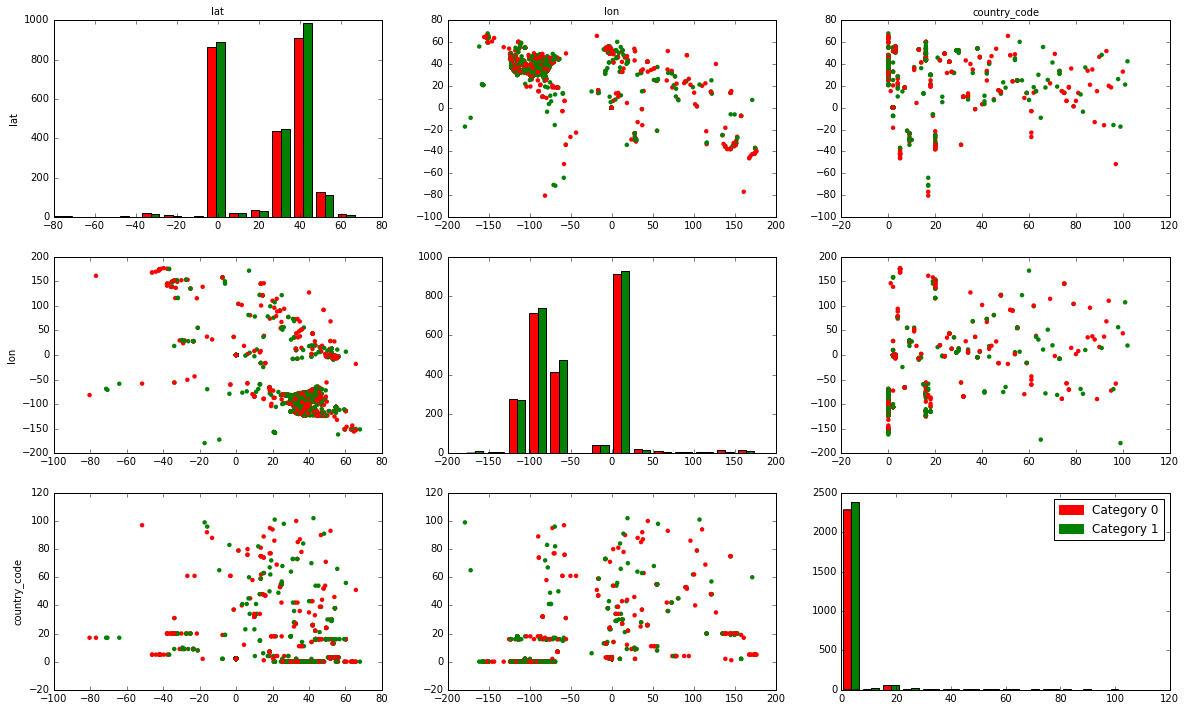

In [8]:
geo_features_new = ["lat", "lon", "country_code"]
geo_features = [f for f in geo_features_new if f in features]

geo_feature_ind = [i for i, f in enumerate(features) if f in geo_features]
plot_dataset(x[:, geo_feature_ind], y, geo_features,legend=True)

Социальные признаки (официальность, количество статусов, фолловеров, друзей.. год создания):

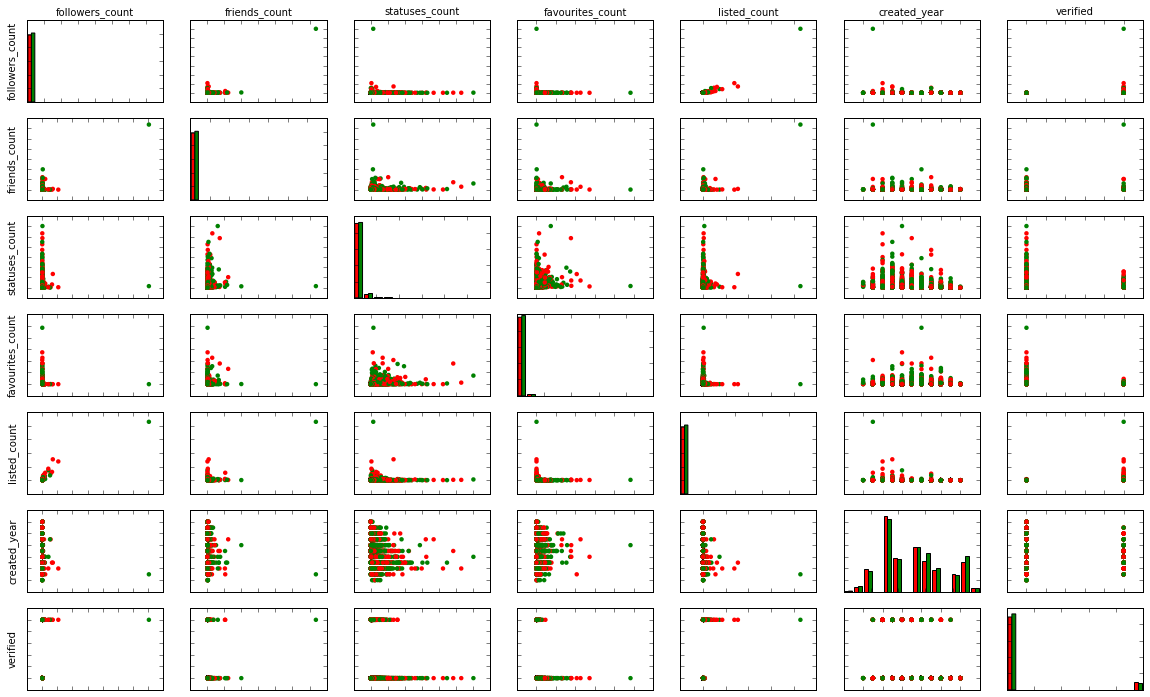

In [9]:
social_features_new = ["followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year","verified"]
social_features = [f for f in social_features_new if f in features]
social_feature_ind = [i for i, f in enumerate(features) if f in social_features]
plot_dataset(x[:, social_feature_ind], y, social_features,axis_values=False)

Поскольку графики зависимостей некоторых признаков смещены в сторону небольших значений и выглядят ненаглядно из-за одиночных выбросов в очень больших значениях, прологарифмируем массив признаков:

In [10]:
def log_transform_features(data, features, transformed_features):
    for i in transformed_features:
        for ind,j in enumerate(features):
            if i==j:
                x.T[ind]=log1p(x.T[ind])
    return data

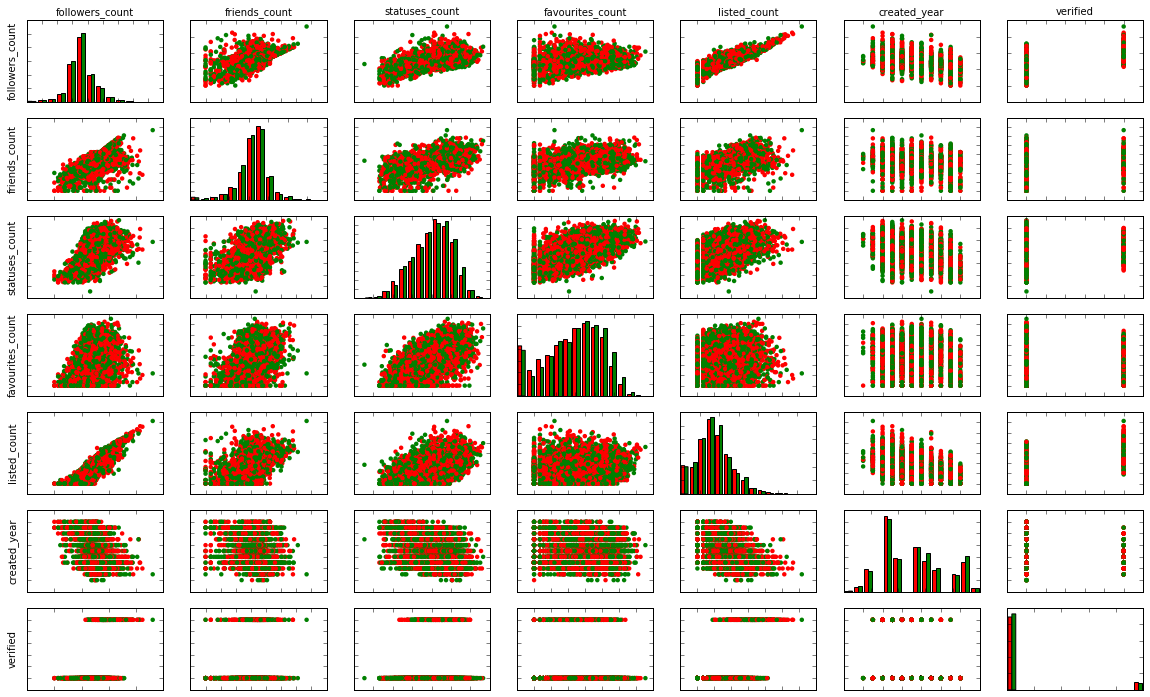

In [11]:
transformed_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
x = log_transform_features(x, features, transformed_features)
# Re-plot features
plot_dataset(x[:, social_feature_ind], y, social_features,axis_values=False)

Напоследок построим попарные распределения остальных признаков:

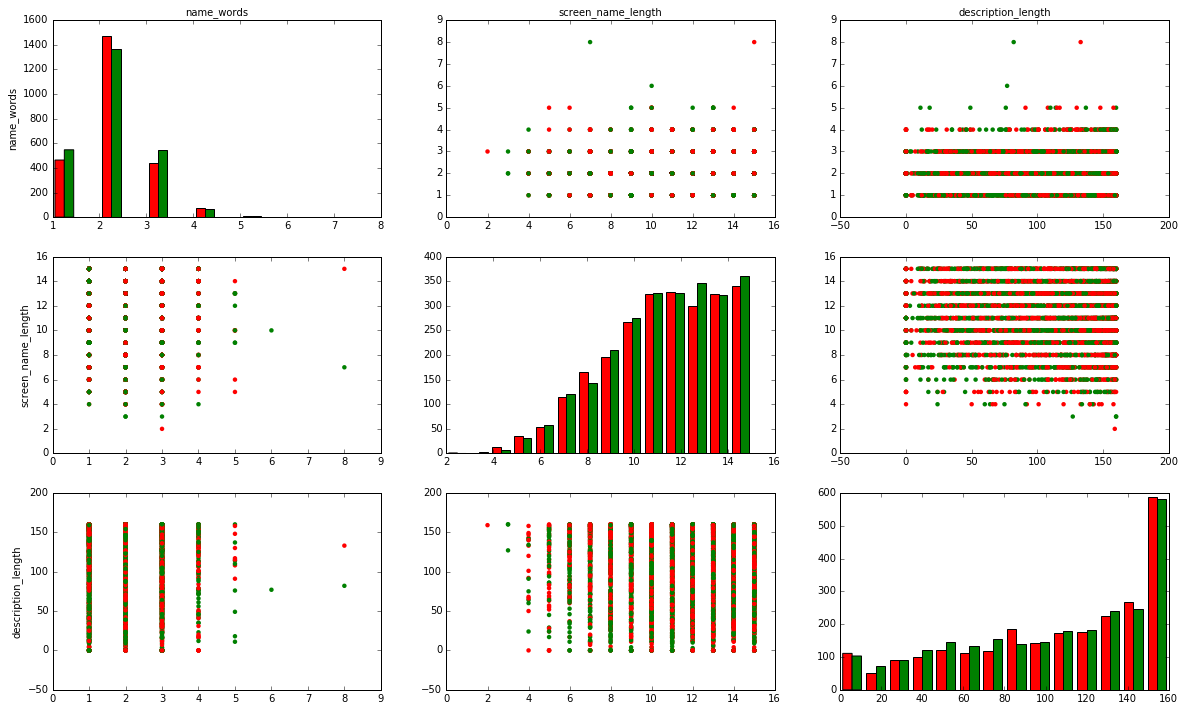

In [12]:
other_features_new = ["name_words", "screen_name_length", "description_length"]
other_features = [f for f in other_features_new if f in features]
other_feature_ind = [i for i, f in enumerate(features) if f in other_features]
plot_dataset(x[:, other_feature_ind], y, other_features)

Для последующей кластеризации сохраним значения признаков в интервале $[0;1]$:

In [13]:
selected_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", 
                     "listed_count", "name_words", "screen_name_length", "description_length", "created_year"]

x_1 = df_users[selected_features].values
y = df_users["cat"].values

np.nan_to_num(x_1)
x_min = x_1.min(axis=0)
x_max = x_1.max(axis=0)
x_new = (x_1 - x_min) / (x_max - x_min)

И сохраним в файл:

In [14]:
df_out = pd.DataFrame(data=x_new, index=df_users["uid"], columns=[f for f in selected_features])
df_out.to_csv("hw2_out.csv", sep=",")
df_out.head()

,followers_count,friends_count,statuses_count,favourites_count,listed_count,name_words,screen_name_length,description_length,created_year
uid,,,,,,,,,
40585382,0.000108,0.006718,0.083903,0.001628,0.001943,0.142857,0.692308,0.72500,0.3
30005269,0.000027,0.001945,0.011822,0.000265,0.000447,0.142857,0.384615,0.98125,0.3
3314758074,0.000250,0.019513,0.001490,0.014481,0.000732,0.142857,0.923077,0.90000,0.9
14311688,0.000025,0.002027,0.012147,0.000325,0.000517,0.142857,0.923077,0.71250,0.2
110457801,0.000021,0.001865,0.061441,0.006843,0.000368,0.142857,0.384615,0.94375,0.4
